# WUR historical phenotypic barley data analysis
origin and version of the input file: https://urgi.versailles.inrae.fr/fairdom/data_files/15?version=6

## Load packages, custom functions and data

In [1]:
library(readxl)
library(tidyverse)
library(multtest)
library(asreml)

source("../custom_functions.r")

── Attaching core tidyverse packages ──────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, ap

Online License checked out Thu Sep  5 23:42:50 2024


Loading ASReml-R version 4.2




In [2]:
data_total <- preprocess("WR-Phenotypic-Historical-Barley-data.xlsx")
write_csv(data_total, "WUR_barley.csv")
genotypes <- distinct(data_total["accenumb"]) |> rename("genotype" = "accenumb")
cat("barley data:\n", nrow(data_total), "observations\n", nrow(genotypes), "genotypes\n", nrow(distinct(data_total["campaign"])), "campaigns\n\n")
summary(data_total[c("days_to_heading", "plant_height", "thousand_kernel_weight")])

barley data:
 2603 observations
 2047 genotypes
 19 campaigns



 days_to_heading  plant_height   thousand_kernel_weight
 Min.   :136.0   Min.   : 10.0   Min.   : 24.10        
 1st Qu.:151.0   1st Qu.: 80.0   1st Qu.: 41.40        
 Median :160.0   Median : 92.0   Median : 46.50        
 Mean   :163.8   Mean   : 92.9   Mean   : 46.55        
 3rd Qu.:174.5   3rd Qu.:105.0   3rd Qu.: 51.50        
 Max.   :211.0   Max.   :145.0   Max.   :106.50        
 NA's   :2359    NA's   :7       NA's   :2088          

Warning message:
“Coercing text to numeric in AE1564 / R1564C31: '3'”


Warning message:
“Coercing text to numeric in U1565 / R1565C21: '5'”


Warning message:
“Coercing text to numeric in AE1565 / R1565C31: '3'”


Warning message:
“Coercing text to numeric in U1566 / R1566C21: '5'”


Warning message:
“Coercing text to numeric in AE1566 / R1566C31: '3'”


Warning message:
“Coercing text to numeric in U1567 / R1567C21: '5'”


Warning message:
“Coercing text to numeric in AE1567 / R1567C31: '3'”


Warning message:
“Coercing text to numeric in U1568 / R1568C21: '6'”


Warning message:
“Coercing text to numeric in AE1568 / R1568C31: '3'”


Warning message:
“Coercing text to numeric in U1569 / R1569C21: '6'”


Warning message:
“Coercing text to numeric in AE1569 / R1569C31: '3'”


Warning message:
“Coercing text to numeric in U1570 / R1570C21: '6'”


Warning message:
“Coercing text to numeric in AE1570 / R1570C31: '3'”


Warning message:
“Coercing text to numeric in U1571 / R1571C21: '6'”


Warning message:
“Coercing text to numeric in AE1571 / R1571C31: '2'”


Warning message:
“Coercing text to numeric in U1572 / R1572C21: '6'”


Warning message:
“Coercing text to numeric in AE1572 / R1572C31: '2'”


Warning message:
“Coercing text to numeric in U1573 / R1573C21: '6'”


Warning message:
“Coercing text to numeric in AE1573 / R1573C31: '2'”


Warning message:
“Coercing text to numeric in U1574 / R1574C21: '6'”


Warning message:
“Coercing text to numeric in AE1574 / R1574C31: '3'”


Warning message:
“Coercing text to numeric in U1575 / R1575C21: '6'”


Warning message:
“Coercing text to numeric in AE1575 / R1575C31: '3'”


Warning message:
“Coercing text to numeric in U1576 / R1576C21: '6'”


Warning message:
“Coercing text to numeric in AE1576 / R1576C31: '3'”


Warning message:
“Coercing text to numeric in U1577 / R1577C21: '6'”


Warning message:
“Coercing text to numeric in AE1577 / R1577C31: '3'”


Warning message:
“Coercing text to numeric in U1578 / R1578C21: '6'”


Warning message:
“Coercing text to numeric in AE1578 / R1578C31: '3'”


Warning message:
“Coercing text to numeric in U1579 / R1579C21: '6'”


Warning message:
“Coercing text to numeric in AE1579 / R1579C31: '3'”


Warning message:
“Coercing text to numeric in U1580 / R1580C21: '6'”


Warning message:
“Coercing text to numeric in AD1580 / R1580C30: '7'”


Warning message:
“Coercing text to numeric in AE1580 / R1580C31: '3'”


Warning message:
“Coercing text to numeric in U1581 / R1581C21: '6'”


Warning message:
“Coercing text to numeric in AD1581 / R1581C30: '7'”


Warning message:
“Coercing text to numeric in AE1581 / R1581C31: '3'”


Warning message:
“Coercing text to numeric in U1582 / R1582C21: '6'”


Warning message:
“Coercing text to numeric in AD1582 / R1582C30: '7'”


Warning message:
“Coercing text to numeric in AE1582 / R1582C31: '3'”


Warning message:
“Coercing text to numeric in U1583 / R1583C21: '6'”


Warning message:
“Coercing text to numeric in AD1583 / R1583C30: '3'”


Warning message:
“Coercing text to numeric in AE1583 / R1583C31: '3'”


Warning message:
“Coercing text to numeric in U1584 / R1584C21: '6'”


Warning message:
“Coercing text to numeric in AD1584 / R1584C30: '3'”


Warning message:
“Coercing text to numeric in AE1584 / R1584C31: '3'”


Warning message:
“Coercing text to numeric in U1585 / R1585C21: '6'”


Warning message:
“Coercing text to numeric in AD1585 / R1585C30: '3'”


Warning message:
“Coercing text to numeric in AE1585 / R1585C31: '3'”


Warning message:
“Coercing text to numeric in U1586 / R1586C21: '6'”


Warning message:
“Coercing text to numeric in AD1586 / R1586C30: '3'”


Warning message:
“Coercing text to numeric in AE1586 / R1586C31: '2'”


Warning message:
“Coercing text to numeric in U1587 / R1587C21: '6'”


Warning message:
“Coercing text to numeric in AD1587 / R1587C30: '3'”


Warning message:
“Coercing text to numeric in AE1587 / R1587C31: '2'”


Warning message:
“Coercing text to numeric in U1588 / R1588C21: '6'”


Warning message:
“Coercing text to numeric in AD1588 / R1588C30: '3'”


Warning message:
“Coercing text to numeric in AE1588 / R1588C31: '2'”


Warning message:
“Coercing text to numeric in U1589 / R1589C21: '6'”


Warning message:
“Coercing text to numeric in AD1589 / R1589C30: '3'”


Warning message:
“Coercing text to numeric in AE1589 / R1589C31: '3'”


Warning message:
“Coercing text to numeric in U1590 / R1590C21: '6'”


Warning message:
“Coercing text to numeric in AD1590 / R1590C30: '3'”


Warning message:
“Coercing text to numeric in AE1590 / R1590C31: '3'”


Warning message:
“Coercing text to numeric in U1591 / R1591C21: '6'”


Warning message:
“Coercing text to numeric in AD1591 / R1591C30: '3'”


Warning message:
“Coercing text to numeric in AE1591 / R1591C31: '3'”


Warning message:
“Coercing text to numeric in U1592 / R1592C21: '5'”


Warning message:
“Coercing text to numeric in AD1592 / R1592C30: '7'”


Warning message:
“Coercing text to numeric in AE1592 / R1592C31: '3'”


Warning message:
“Coercing text to numeric in U1593 / R1593C21: '5'”


Warning message:
“Coercing text to numeric in AD1593 / R1593C30: '7'”


Warning message:
“Coercing text to numeric in AE1593 / R1593C31: '3'”


Warning message:
“Coercing text to numeric in U1594 / R1594C21: '5'”


Warning message:
“Coercing text to numeric in AD1594 / R1594C30: '7'”


Warning message:
“Coercing text to numeric in AE1594 / R1594C31: '3'”


Warning message:
“Coercing text to numeric in U1595 / R1595C21: '6'”


Warning message:
“Coercing text to numeric in AD1595 / R1595C30: '3'”


Warning message:
“Coercing text to numeric in AE1595 / R1595C31: '3'”


Warning message:
“Coercing text to numeric in U1596 / R1596C21: '6'”


Warning message:
“Coercing text to numeric in AD1596 / R1596C30: '3'”


Warning message:
“Coercing text to numeric in AE1596 / R1596C31: '3'”


Warning message:
“Coercing text to numeric in U1597 / R1597C21: '6'”


Warning message:
“Coercing text to numeric in AD1597 / R1597C30: '3'”


Warning message:
“Coercing text to numeric in AE1597 / R1597C31: '3'”


Warning message:
“Coercing text to numeric in U1598 / R1598C21: '6'”


Warning message:
“Coercing text to numeric in AD1598 / R1598C30: '3'”


Warning message:
“Coercing text to numeric in AE1598 / R1598C31: '2'”


Warning message:
“Coercing text to numeric in U1599 / R1599C21: '6'”


Warning message:
“Coercing text to numeric in AD1599 / R1599C30: '3'”


Warning message:
“Coercing text to numeric in AE1599 / R1599C31: '2'”


Warning message:
“Coercing text to numeric in U1600 / R1600C21: '6'”


Warning message:
“Coercing text to numeric in AD1600 / R1600C30: '3'”


Warning message:
“Coercing text to numeric in AE1600 / R1600C31: '2'”


Warning message:
“Coercing text to numeric in U1601 / R1601C21: '5'”


Warning message:
“Coercing text to numeric in AD1601 / R1601C30: '3'”


Warning message:
“Coercing text to numeric in AE1601 / R1601C31: '3'”


Warning message:
“Coercing text to numeric in U1602 / R1602C21: '5'”


Warning message:
“Coercing text to numeric in AD1602 / R1602C30: '3'”


Warning message:
“Coercing text to numeric in AE1602 / R1602C31: '3'”


Warning message:
“Coercing text to numeric in U1603 / R1603C21: '5'”


Warning message:
“Coercing text to numeric in AD1603 / R1603C30: '3'”


Warning message:
“Coercing text to numeric in AE1603 / R1603C31: '3'”


Warning message:
“Coercing text to numeric in U1604 / R1604C21: '5'”


Warning message:
“Coercing text to numeric in AD1604 / R1604C30: '3'”


Warning message:
“Coercing text to numeric in AE1604 / R1604C31: '3'”


Warning message:
“Coercing text to numeric in U1605 / R1605C21: '5'”


Warning message:
“Coercing text to numeric in AD1605 / R1605C30: '3'”


Warning message:
“Coercing text to numeric in AE1605 / R1605C31: '3'”


Warning message:
“Coercing text to numeric in U1606 / R1606C21: '5'”


Warning message:
“Coercing text to numeric in AD1606 / R1606C30: '3'”


Warning message:
“Coercing text to numeric in AE1606 / R1606C31: '3'”


Warning message:
“Coercing text to numeric in U1607 / R1607C21: '5'”


Warning message:
“Coercing text to numeric in AD1607 / R1607C30: '3'”


Warning message:
“Coercing text to numeric in AE1607 / R1607C31: '3'”


Warning message:
“Coercing text to numeric in U1608 / R1608C21: '5'”


Warning message:
“Coercing text to numeric in AD1608 / R1608C30: '3'”


Warning message:
“Coercing text to numeric in AE1608 / R1608C31: '3'”


Warning message:
“Coercing text to numeric in U1609 / R1609C21: '5'”


Warning message:
“Coercing text to numeric in AD1609 / R1609C30: '3'”


Warning message:
“Coercing text to numeric in AE1609 / R1609C31: '3'”


Warning message:
“Coercing text to numeric in U1610 / R1610C21: '6'”


Warning message:
“Coercing text to numeric in AD1610 / R1610C30: '3'”


Warning message:
“Coercing text to numeric in AE1610 / R1610C31: '3'”


Warning message:
“Coercing text to numeric in U1611 / R1611C21: '6'”


Warning message:
“Coercing text to numeric in AD1611 / R1611C30: '3'”


Warning message:
“Coercing text to numeric in AE1611 / R1611C31: '3'”


Warning message:
“Coercing text to numeric in U1612 / R1612C21: '6'”


Warning message:
“Coercing text to numeric in AD1612 / R1612C30: '3'”


Warning message:
“Coercing text to numeric in AE1612 / R1612C31: '3'”


Warning message:
“Coercing text to numeric in U1613 / R1613C21: '6'”


Warning message:
“Coercing text to numeric in AD1613 / R1613C30: '3'”


Warning message:
“Coercing text to numeric in AE1613 / R1613C31: '2'”


Warning message:
“Coercing text to numeric in U1614 / R1614C21: '6'”


Warning message:
“Coercing text to numeric in AD1614 / R1614C30: '3'”


Warning message:
“Coercing text to numeric in AE1614 / R1614C31: '2'”


Warning message:
“Coercing text to numeric in U1615 / R1615C21: '6'”


Warning message:
“Coercing text to numeric in AD1615 / R1615C30: '3'”


Warning message:
“Coercing text to numeric in AE1615 / R1615C31: '2'”


Warning message:
“Coercing text to numeric in U1616 / R1616C21: '6'”


Warning message:
“Coercing text to numeric in AD1616 / R1616C30: '3'”


Warning message:
“Coercing text to numeric in AE1616 / R1616C31: '2'”


Warning message:
“Coercing text to numeric in U1617 / R1617C21: '6'”


Warning message:
“Coercing text to numeric in AD1617 / R1617C30: '3'”


Warning message:
“Coercing text to numeric in AE1617 / R1617C31: '2'”


Warning message:
“Coercing text to numeric in U1618 / R1618C21: '6'”


Warning message:
“Coercing text to numeric in AD1618 / R1618C30: '3'”


Warning message:
“Coercing text to numeric in AE1618 / R1618C31: '2'”


Warning message:
“Coercing text to numeric in U1619 / R1619C21: '6'”


Warning message:
“Coercing text to numeric in AD1619 / R1619C30: '3'”


Warning message:
“Coercing text to numeric in AE1619 / R1619C31: '2'”


Warning message:
“Coercing text to numeric in U1620 / R1620C21: '6'”


Warning message:
“Coercing text to numeric in AD1620 / R1620C30: '3'”


Warning message:
“Coercing text to numeric in AE1620 / R1620C31: '2'”


Warning message:
“Coercing text to numeric in U1621 / R1621C21: '6'”


Warning message:
“Coercing text to numeric in AD1621 / R1621C30: '3'”


Warning message:
“Coercing text to numeric in AE1621 / R1621C31: '2'”


Warning message:
“Coercing text to numeric in U1622 / R1622C21: '6'”


Warning message:
“Coercing text to numeric in AD1622 / R1622C30: '3'”


Warning message:
“Coercing text to numeric in AE1622 / R1622C31: '2'”


Warning message:
“Coercing text to numeric in U1623 / R1623C21: '6'”


Warning message:
“Coercing text to numeric in AD1623 / R1623C30: '3'”


Warning message:
“Coercing text to numeric in AE1623 / R1623C31: '2'”


Warning message:
“Coercing text to numeric in U1624 / R1624C21: '6'”


Warning message:
“Coercing text to numeric in AD1624 / R1624C30: '3'”


Warning message:
“Coercing text to numeric in AE1624 / R1624C31: '2'”


Warning message:
“Coercing text to numeric in U1625 / R1625C21: '6'”


Warning message:
“Coercing text to numeric in AD1625 / R1625C30: '3'”


Warning message:
“Coercing text to numeric in AE1625 / R1625C31: '3'”


Warning message:
“Coercing text to numeric in U1626 / R1626C21: '6'”


Warning message:
“Coercing text to numeric in AD1626 / R1626C30: '3'”


Warning message:
“Coercing text to numeric in AE1626 / R1626C31: '3'”


Warning message:
“Coercing text to numeric in U1627 / R1627C21: '6'”


Warning message:
“Coercing text to numeric in AD1627 / R1627C30: '3'”


Warning message:
“Coercing text to numeric in AE1627 / R1627C31: '3'”


Warning message:
“Coercing text to numeric in U1628 / R1628C21: '6'”


Warning message:
“Coercing text to numeric in AD1628 / R1628C30: '3'”


Warning message:
“Coercing text to numeric in AE1628 / R1628C31: '2'”


Warning message:
“Coercing text to numeric in U1629 / R1629C21: '6'”


Warning message:
“Coercing text to numeric in AD1629 / R1629C30: '3'”


Warning message:
“Coercing text to numeric in AE1629 / R1629C31: '2'”


Warning message:
“Coercing text to numeric in U1630 / R1630C21: '6'”


Warning message:
“Coercing text to numeric in AD1630 / R1630C30: '3'”


Warning message:
“Coercing text to numeric in AE1630 / R1630C31: '2'”


Warning message:
“Coercing text to numeric in U1631 / R1631C21: '6'”


Warning message:
“Coercing text to numeric in AD1631 / R1631C30: '3'”


Warning message:
“Coercing text to numeric in AE1631 / R1631C31: '2'”


Warning message:
“Coercing text to numeric in U1632 / R1632C21: '6'”


Warning message:
“Coercing text to numeric in AD1632 / R1632C30: '3'”


Warning message:
“Coercing text to numeric in AE1632 / R1632C31: '2'”


Warning message:
“Coercing text to numeric in U1633 / R1633C21: '6'”


Warning message:
“Coercing text to numeric in AD1633 / R1633C30: '3'”


Warning message:
“Coercing text to numeric in AE1633 / R1633C31: '2'”


Warning message:
“Coercing text to numeric in U1634 / R1634C21: '6'”


Warning message:
“Coercing text to numeric in AD1634 / R1634C30: '3'”


Warning message:
“Coercing text to numeric in AE1634 / R1634C31: '3'”


Warning message:
“Coercing text to numeric in U1635 / R1635C21: '6'”


Warning message:
“Coercing text to numeric in AD1635 / R1635C30: '3'”


Warning message:
“Coercing text to numeric in AE1635 / R1635C31: '3'”


Warning message:
“Coercing text to numeric in U1636 / R1636C21: '6'”


Warning message:
“Coercing text to numeric in AD1636 / R1636C30: '3'”


Warning message:
“Coercing text to numeric in AE1636 / R1636C31: '3'”


Warning message:
“Coercing text to numeric in U1637 / R1637C21: '6'”


Warning message:
“Coercing text to numeric in AD1637 / R1637C30: '3'”


Warning message:
“Coercing text to numeric in AE1637 / R1637C31: '3'”


Warning message:
“Coercing text to numeric in U1638 / R1638C21: '6'”


Warning message:
“Coercing text to numeric in AD1638 / R1638C30: '3'”


Warning message:
“Coercing text to numeric in AE1638 / R1638C31: '3'”


Warning message:
“Coercing text to numeric in U1639 / R1639C21: '6'”


Warning message:
“Coercing text to numeric in AD1639 / R1639C30: '3'”


Warning message:
“Coercing text to numeric in AE1639 / R1639C31: '3'”


Warning message:
“Coercing text to numeric in U1640 / R1640C21: '5'”


Warning message:
“Coercing text to numeric in AD1640 / R1640C30: '3'”


Warning message:
“Coercing text to numeric in AE1640 / R1640C31: '3'”


Warning message:
“Coercing text to numeric in U1641 / R1641C21: '5'”


Warning message:
“Coercing text to numeric in AD1641 / R1641C30: '3'”


Warning message:
“Coercing text to numeric in AE1641 / R1641C31: '3'”


Warning message:
“Coercing text to numeric in U1642 / R1642C21: '5'”


Warning message:
“Coercing text to numeric in AD1642 / R1642C30: '3'”


Warning message:
“Coercing text to numeric in AE1642 / R1642C31: '3'”


Warning message:
“Coercing text to numeric in U1643 / R1643C21: '5'”


Warning message:
“Coercing text to numeric in AD1643 / R1643C30: '3'”


Warning message:
“Coercing text to numeric in AE1643 / R1643C31: '2'”


Warning message:
“Coercing text to numeric in U1644 / R1644C21: '5'”


Warning message:
“Coercing text to numeric in AD1644 / R1644C30: '3'”


Warning message:
“Coercing text to numeric in AE1644 / R1644C31: '2'”


Warning message:
“Coercing text to numeric in U1645 / R1645C21: '5'”


Warning message:
“Coercing text to numeric in AD1645 / R1645C30: '3'”


Warning message:
“Coercing text to numeric in AE1645 / R1645C31: '2'”


Warning message:
“Coercing text to numeric in U1646 / R1646C21: '5'”


Warning message:
“Coercing text to numeric in AD1646 / R1646C30: '3'”


Warning message:
“Coercing text to numeric in AE1646 / R1646C31: '3'”


Warning message:
“Coercing text to numeric in U1647 / R1647C21: '5'”


Warning message:
“Coercing text to numeric in AD1647 / R1647C30: '3'”


Warning message:
“Coercing text to numeric in AE1647 / R1647C31: '3'”


Warning message:
“Coercing text to numeric in U1648 / R1648C21: '5'”


Warning message:
“Coercing text to numeric in AD1648 / R1648C30: '3'”


Warning message:
“Coercing text to numeric in AE1648 / R1648C31: '3'”


Warning message:
“Coercing text to numeric in U1649 / R1649C21: '4'”


Warning message:
“Coercing text to numeric in AD1649 / R1649C30: '3'”


Warning message:
“Coercing text to numeric in AE1649 / R1649C31: '3'”


Warning message:
“Coercing text to numeric in U1650 / R1650C21: '4'”


Warning message:
“Coercing text to numeric in AD1650 / R1650C30: '3'”


Warning message:
“Coercing text to numeric in AE1650 / R1650C31: '3'”


Warning message:
“Coercing text to numeric in U1651 / R1651C21: '4'”


Warning message:
“Coercing text to numeric in AD1651 / R1651C30: '3'”


Warning message:
“Coercing text to numeric in AE1651 / R1651C31: '3'”


Warning message:
“Coercing text to numeric in U1652 / R1652C21: '2'”


Warning message:
“Coercing text to numeric in AD1652 / R1652C30: '3'”


Warning message:
“Coercing text to numeric in AE1652 / R1652C31: '3'”


Warning message:
“Coercing text to numeric in U1653 / R1653C21: '2'”


Warning message:
“Coercing text to numeric in AD1653 / R1653C30: '3'”


Warning message:
“Coercing text to numeric in AE1653 / R1653C31: '3'”


Warning message:
“Coercing text to numeric in U1654 / R1654C21: '2'”


Warning message:
“Coercing text to numeric in AD1654 / R1654C30: '3'”


Warning message:
“Coercing text to numeric in AE1654 / R1654C31: '3'”


Warning message:
“Coercing text to numeric in U1655 / R1655C21: '2'”


Warning message:
“Coercing text to numeric in AD1655 / R1655C30: '3'”


Warning message:
“Coercing text to numeric in AE1655 / R1655C31: '3'”


Warning message:
“Coercing text to numeric in U1656 / R1656C21: '2'”


Warning message:
“Coercing text to numeric in AD1656 / R1656C30: '3'”


Warning message:
“Coercing text to numeric in AE1656 / R1656C31: '3'”


Warning message:
“Coercing text to numeric in U1657 / R1657C21: '2'”


Warning message:
“Coercing text to numeric in AD1657 / R1657C30: '3'”


Warning message:
“Coercing text to numeric in AE1657 / R1657C31: '3'”


Warning message:
“Coercing text to numeric in U1658 / R1658C21: '2'”


Warning message:
“Coercing text to numeric in AD1658 / R1658C30: '3'”


Warning message:
“Coercing text to numeric in AE1658 / R1658C31: '3'”


Warning message:
“Coercing text to numeric in U1659 / R1659C21: '2'”


Warning message:
“Coercing text to numeric in AD1659 / R1659C30: '3'”


Warning message:
“Coercing text to numeric in AE1659 / R1659C31: '3'”


Warning message:
“Coercing text to numeric in U1660 / R1660C21: '2'”


Warning message:
“Coercing text to numeric in AD1660 / R1660C30: '3'”


Warning message:
“Coercing text to numeric in AE1660 / R1660C31: '3'”


Warning message:
“Coercing text to numeric in U1661 / R1661C21: '2'”


Warning message:
“Coercing text to numeric in AD1661 / R1661C30: '3'”


Warning message:
“Coercing text to numeric in AE1661 / R1661C31: '3'”


Warning message:
“Coercing text to numeric in U1662 / R1662C21: '2'”


Warning message:
“Coercing text to numeric in AD1662 / R1662C30: '3'”


Warning message:
“Coercing text to numeric in AE1662 / R1662C31: '3'”


Warning message:
“Coercing text to numeric in U1663 / R1663C21: '2'”


Warning message:
“Coercing text to numeric in AD1663 / R1663C30: '3'”


Warning message:
“Coercing text to numeric in AE1663 / R1663C31: '3'”


Warning message:
“Coercing text to numeric in U1664 / R1664C21: '2'”


Warning message:
“Coercing text to numeric in AD1664 / R1664C30: '3'”


Warning message:
“Coercing text to numeric in AE1664 / R1664C31: '3'”


Warning message:
“Coercing text to numeric in U1665 / R1665C21: '2'”


Warning message:
“Coercing text to numeric in AD1665 / R1665C30: '3'”


Warning message:
“Coercing text to numeric in AE1665 / R1665C31: '3'”


Warning message:
“Coercing text to numeric in U1666 / R1666C21: '2'”


Warning message:
“Coercing text to numeric in AD1666 / R1666C30: '3'”


Warning message:
“Coercing text to numeric in AE1666 / R1666C31: '3'”


Warning message:
“Coercing text to numeric in U1667 / R1667C21: '4'”


Warning message:
“Coercing text to numeric in AD1667 / R1667C30: '3'”


Warning message:
“Coercing text to numeric in AE1667 / R1667C31: '3'”


Warning message:
“Coercing text to numeric in U1668 / R1668C21: '4'”


Warning message:
“Coercing text to numeric in AD1668 / R1668C30: '3'”


Warning message:
“Coercing text to numeric in AE1668 / R1668C31: '3'”


Warning message:
“Coercing text to numeric in U1669 / R1669C21: '4'”


Warning message:
“Coercing text to numeric in AD1669 / R1669C30: '3'”


Warning message:
“Coercing text to numeric in AE1669 / R1669C31: '3'”


Warning message:
“Coercing text to numeric in U1670 / R1670C21: '2'”


Warning message:
“Coercing text to numeric in AD1670 / R1670C30: '3'”


Warning message:
“Coercing text to numeric in AE1670 / R1670C31: '3'”


Warning message:
“Coercing text to numeric in U1671 / R1671C21: '2'”


Warning message:
“Coercing text to numeric in AD1671 / R1671C30: '3'”


Warning message:
“Coercing text to numeric in AE1671 / R1671C31: '3'”


Warning message:
“Coercing text to numeric in U1672 / R1672C21: '2'”


Warning message:
“Coercing text to numeric in AD1672 / R1672C30: '3'”


Warning message:
“Coercing text to numeric in AE1672 / R1672C31: '3'”


Warning message:
“Coercing text to numeric in U1673 / R1673C21: '2'”


Warning message:
“Coercing text to numeric in AD1673 / R1673C30: '3'”


Warning message:
“Coercing text to numeric in AE1673 / R1673C31: '3'”


Warning message:
“Coercing text to numeric in U1674 / R1674C21: '2'”


Warning message:
“Coercing text to numeric in AD1674 / R1674C30: '3'”


Warning message:
“Coercing text to numeric in AE1674 / R1674C31: '3'”


Warning message:
“Coercing text to numeric in U1675 / R1675C21: '2'”


Warning message:
“Coercing text to numeric in AD1675 / R1675C30: '3'”


Warning message:
“Coercing text to numeric in AE1675 / R1675C31: '3'”


Warning message:
“Coercing text to numeric in U1676 / R1676C21: '2'”


Warning message:
“Coercing text to numeric in AD1676 / R1676C30: '3'”


Warning message:
“Coercing text to numeric in AE1676 / R1676C31: '3'”


Warning message:
“Coercing text to numeric in U1677 / R1677C21: '2'”


Warning message:
“Coercing text to numeric in AD1677 / R1677C30: '3'”


Warning message:
“Coercing text to numeric in AE1677 / R1677C31: '3'”


Warning message:
“Coercing text to numeric in U1678 / R1678C21: '2'”


Warning message:
“Coercing text to numeric in AD1678 / R1678C30: '3'”


Warning message:
“Coercing text to numeric in AE1678 / R1678C31: '3'”


Warning message:
“Coercing text to numeric in U1679 / R1679C21: '2'”


Warning message:
“Coercing text to numeric in AD1679 / R1679C30: '3'”


Warning message:
“Coercing text to numeric in AE1679 / R1679C31: '3'”


Warning message:
“Coercing text to numeric in U1680 / R1680C21: '2'”


Warning message:
“Coercing text to numeric in AD1680 / R1680C30: '3'”


Warning message:
“Coercing text to numeric in AE1680 / R1680C31: '3'”


Warning message:
“Coercing text to numeric in U1681 / R1681C21: '2'”


Warning message:
“Coercing text to numeric in AD1681 / R1681C30: '3'”


Warning message:
“Coercing text to numeric in AE1681 / R1681C31: '3'”


Warning message:
“Coercing text to numeric in U1682 / R1682C21: '6'”


Warning message:
“Coercing text to numeric in AD1682 / R1682C30: '3'”


Warning message:
“Coercing text to numeric in AE1682 / R1682C31: '3'”


Warning message:
“Coercing text to numeric in U1683 / R1683C21: '6'”


Warning message:
“Coercing text to numeric in AD1683 / R1683C30: '3'”


Warning message:
“Coercing text to numeric in AE1683 / R1683C31: '3'”


Warning message:
“Coercing text to numeric in U1684 / R1684C21: '6'”


Warning message:
“Coercing text to numeric in AD1684 / R1684C30: '3'”


Warning message:
“Coercing text to numeric in AE1684 / R1684C31: '3'”


Warning message:
“Coercing text to numeric in U1685 / R1685C21: '5'”


Warning message:
“Coercing text to numeric in AD1685 / R1685C30: '3'”


Warning message:
“Coercing text to numeric in AE1685 / R1685C31: '3'”


Warning message:
“Coercing text to numeric in U1686 / R1686C21: '5'”


Warning message:
“Coercing text to numeric in AD1686 / R1686C30: '3'”


Warning message:
“Coercing text to numeric in AE1686 / R1686C31: '3'”


Warning message:
“Coercing text to numeric in U1687 / R1687C21: '5'”


Warning message:
“Coercing text to numeric in AD1687 / R1687C30: '3'”


Warning message:
“Coercing text to numeric in AE1687 / R1687C31: '3'”


Warning message:
“Coercing text to numeric in U1688 / R1688C21: '6'”


Warning message:
“Coercing text to numeric in AD1688 / R1688C30: '3'”


Warning message:
“Coercing text to numeric in AE1688 / R1688C31: '3'”


Warning message:
“Coercing text to numeric in U1689 / R1689C21: '6'”


Warning message:
“Coercing text to numeric in AD1689 / R1689C30: '3'”


Warning message:
“Coercing text to numeric in AE1689 / R1689C31: '3'”


Warning message:
“Coercing text to numeric in U1690 / R1690C21: '6'”


Warning message:
“Coercing text to numeric in AD1690 / R1690C30: '3'”


Warning message:
“Coercing text to numeric in AE1690 / R1690C31: '3'”


Warning message:
“Coercing text to numeric in U1691 / R1691C21: '4'”


Warning message:
“Coercing text to numeric in AD1691 / R1691C30: '3'”


Warning message:
“Coercing text to numeric in AE1691 / R1691C31: '3'”


Warning message:
“Coercing text to numeric in U1692 / R1692C21: '4'”


Warning message:
“Coercing text to numeric in AD1692 / R1692C30: '3'”


Warning message:
“Coercing text to numeric in AE1692 / R1692C31: '3'”


Warning message:
“Coercing text to numeric in U1693 / R1693C21: '4'”


Warning message:
“Coercing text to numeric in AD1693 / R1693C30: '3'”


Warning message:
“Coercing text to numeric in AE1693 / R1693C31: '3'”


Warning message:
“Coercing text to numeric in U1694 / R1694C21: '6'”


Warning message:
“Coercing text to numeric in AD1694 / R1694C30: '3'”


Warning message:
“Coercing text to numeric in AE1694 / R1694C31: '3'”


Warning message:
“Coercing text to numeric in U1695 / R1695C21: '6'”


Warning message:
“Coercing text to numeric in AD1695 / R1695C30: '3'”


Warning message:
“Coercing text to numeric in AE1695 / R1695C31: '3'”


Warning message:
“Coercing text to numeric in U1696 / R1696C21: '6'”


Warning message:
“Coercing text to numeric in AD1696 / R1696C30: '3'”


Warning message:
“Coercing text to numeric in AE1696 / R1696C31: '3'”


Warning message:
“Coercing text to numeric in U1697 / R1697C21: '6'”


Warning message:
“Coercing text to numeric in AD1697 / R1697C30: '3'”


Warning message:
“Coercing text to numeric in AE1697 / R1697C31: '2'”


Warning message:
“Coercing text to numeric in U1698 / R1698C21: '6'”


Warning message:
“Coercing text to numeric in AD1698 / R1698C30: '3'”


Warning message:
“Coercing text to numeric in AE1698 / R1698C31: '2'”


Warning message:
“Coercing text to numeric in U1699 / R1699C21: '6'”


Warning message:
“Coercing text to numeric in AD1699 / R1699C30: '3'”


Warning message:
“Coercing text to numeric in AE1699 / R1699C31: '2'”


Warning message:
“Coercing text to numeric in U1700 / R1700C21: '6'”


Warning message:
“Coercing text to numeric in AD1700 / R1700C30: '3'”


Warning message:
“Coercing text to numeric in AE1700 / R1700C31: '1'”


Warning message:
“Coercing text to numeric in U1701 / R1701C21: '6'”


Warning message:
“Coercing text to numeric in AD1701 / R1701C30: '3'”


Warning message:
“Coercing text to numeric in AE1701 / R1701C31: '1'”


Warning message:
“Coercing text to numeric in U1702 / R1702C21: '6'”


Warning message:
“Coercing text to numeric in AD1702 / R1702C30: '3'”


Warning message:
“Coercing text to numeric in AE1702 / R1702C31: '1'”


Warning message:
“Coercing text to numeric in U1703 / R1703C21: '2'”


Warning message:
“Coercing text to numeric in AD1703 / R1703C30: '3'”


Warning message:
“Coercing text to numeric in AE1703 / R1703C31: '2'”


Warning message:
“Coercing text to numeric in U1704 / R1704C21: '2'”


Warning message:
“Coercing text to numeric in AD1704 / R1704C30: '3'”


Warning message:
“Coercing text to numeric in AE1704 / R1704C31: '2'”


Warning message:
“Coercing text to numeric in U1705 / R1705C21: '2'”


Warning message:
“Coercing text to numeric in AD1705 / R1705C30: '3'”


Warning message:
“Coercing text to numeric in AE1705 / R1705C31: '2'”


Warning message:
“Coercing text to numeric in U1706 / R1706C21: '6'”


Warning message:
“Coercing text to numeric in AD1706 / R1706C30: '3'”


Warning message:
“Coercing text to numeric in AE1706 / R1706C31: '3'”


Warning message:
“Coercing text to numeric in U1707 / R1707C21: '6'”


Warning message:
“Coercing text to numeric in AD1707 / R1707C30: '3'”


Warning message:
“Coercing text to numeric in AE1707 / R1707C31: '3'”


Warning message:
“Coercing text to numeric in U1708 / R1708C21: '6'”


Warning message:
“Coercing text to numeric in AD1708 / R1708C30: '3'”


Warning message:
“Coercing text to numeric in AE1708 / R1708C31: '3'”


Warning message:
“Coercing text to numeric in U1709 / R1709C21: '6'”


Warning message:
“Coercing text to numeric in AD1709 / R1709C30: '3'”


Warning message:
“Coercing text to numeric in AE1709 / R1709C31: '3'”


Warning message:
“Coercing text to numeric in U1710 / R1710C21: '6'”


Warning message:
“Coercing text to numeric in AD1710 / R1710C30: '3'”


Warning message:
“Coercing text to numeric in AE1710 / R1710C31: '3'”


Warning message:
“Coercing text to numeric in U1711 / R1711C21: '6'”


Warning message:
“Coercing text to numeric in AD1711 / R1711C30: '3'”


Warning message:
“Coercing text to numeric in AE1711 / R1711C31: '3'”


Warning message:
“Coercing text to numeric in U1712 / R1712C21: '6'”


Warning message:
“Coercing text to numeric in AD1712 / R1712C30: '3'”


Warning message:
“Coercing text to numeric in AE1712 / R1712C31: '2'”


Warning message:
“Coercing text to numeric in U1713 / R1713C21: '6'”


Warning message:
“Coercing text to numeric in AD1713 / R1713C30: '3'”


Warning message:
“Coercing text to numeric in AE1713 / R1713C31: '2'”


Warning message:
“Coercing text to numeric in U1714 / R1714C21: '6'”


Warning message:
“Coercing text to numeric in AD1714 / R1714C30: '3'”


Warning message:
“Coercing text to numeric in AE1714 / R1714C31: '2'”


Warning message:
“Coercing text to numeric in U1715 / R1715C21: '6'”


Warning message:
“Coercing text to numeric in AD1715 / R1715C30: '3'”


Warning message:
“Coercing text to numeric in AE1715 / R1715C31: '2'”


Warning message:
“Coercing text to numeric in U1716 / R1716C21: '6'”


Warning message:
“Coercing text to numeric in AD1716 / R1716C30: '3'”


Warning message:
“Coercing text to numeric in AE1716 / R1716C31: '2'”


Warning message:
“Coercing text to numeric in U1717 / R1717C21: '6'”


Warning message:
“Coercing text to numeric in AD1717 / R1717C30: '3'”


Warning message:
“Coercing text to numeric in AE1717 / R1717C31: '2'”


Warning message:
“Coercing text to numeric in U1718 / R1718C21: '6'”


Warning message:
“Coercing text to numeric in AD1718 / R1718C30: '3'”


Warning message:
“Coercing text to numeric in AE1718 / R1718C31: '3'”


Warning message:
“Coercing text to numeric in U1719 / R1719C21: '6'”


Warning message:
“Coercing text to numeric in AD1719 / R1719C30: '3'”


Warning message:
“Coercing text to numeric in AE1719 / R1719C31: '3'”


Warning message:
“Coercing text to numeric in U1720 / R1720C21: '6'”


Warning message:
“Coercing text to numeric in AD1720 / R1720C30: '3'”


Warning message:
“Coercing text to numeric in AE1720 / R1720C31: '3'”


Warning message:
“Coercing text to numeric in U1721 / R1721C21: '6'”


Warning message:
“Coercing text to numeric in AD1721 / R1721C30: '3'”


Warning message:
“Coercing text to numeric in AE1721 / R1721C31: '2'”


Warning message:
“Coercing text to numeric in U1722 / R1722C21: '6'”


Warning message:
“Coercing text to numeric in AD1722 / R1722C30: '3'”


Warning message:
“Coercing text to numeric in AE1722 / R1722C31: '2'”


Warning message:
“Coercing text to numeric in U1723 / R1723C21: '6'”


Warning message:
“Coercing text to numeric in AD1723 / R1723C30: '3'”


Warning message:
“Coercing text to numeric in AE1723 / R1723C31: '2'”


Warning message:
“Coercing text to numeric in U1724 / R1724C21: '6'”


Warning message:
“Coercing text to numeric in AD1724 / R1724C30: '3'”


Warning message:
“Coercing text to numeric in AE1724 / R1724C31: '2'”


Warning message:
“Coercing text to numeric in U1725 / R1725C21: '6'”


Warning message:
“Coercing text to numeric in AD1725 / R1725C30: '3'”


Warning message:
“Coercing text to numeric in AE1725 / R1725C31: '2'”


Warning message:
“Coercing text to numeric in U1726 / R1726C21: '6'”


Warning message:
“Coercing text to numeric in AD1726 / R1726C30: '3'”


Warning message:
“Coercing text to numeric in AE1726 / R1726C31: '2'”


Warning message:
“Coercing text to numeric in U1727 / R1727C21: '6'”


Warning message:
“Coercing text to numeric in AD1727 / R1727C30: '3'”


Warning message:
“Coercing text to numeric in AE1727 / R1727C31: '3'”


Warning message:
“Coercing text to numeric in U1728 / R1728C21: '6'”


Warning message:
“Coercing text to numeric in AD1728 / R1728C30: '3'”


Warning message:
“Coercing text to numeric in AE1728 / R1728C31: '3'”


Warning message:
“Coercing text to numeric in U1729 / R1729C21: '6'”


Warning message:
“Coercing text to numeric in AD1729 / R1729C30: '3'”


Warning message:
“Coercing text to numeric in AE1729 / R1729C31: '3'”


Warning message:
“Coercing text to numeric in U1730 / R1730C21: '6'”


Warning message:
“Coercing text to numeric in AD1730 / R1730C30: '3'”


Warning message:
“Coercing text to numeric in AE1730 / R1730C31: '3'”


Warning message:
“Coercing text to numeric in U1731 / R1731C21: '6'”


Warning message:
“Coercing text to numeric in AD1731 / R1731C30: '3'”


Warning message:
“Coercing text to numeric in AE1731 / R1731C31: '3'”


Warning message:
“Coercing text to numeric in U1732 / R1732C21: '6'”


Warning message:
“Coercing text to numeric in AD1732 / R1732C30: '3'”


Warning message:
“Coercing text to numeric in AE1732 / R1732C31: '3'”


Warning message:
“Coercing text to numeric in U1733 / R1733C21: '6'”


Warning message:
“Coercing text to numeric in AD1733 / R1733C30: '3'”


Warning message:
“Coercing text to numeric in AE1733 / R1733C31: '3'”


Warning message:
“Coercing text to numeric in U1734 / R1734C21: '6'”


Warning message:
“Coercing text to numeric in AD1734 / R1734C30: '3'”


Warning message:
“Coercing text to numeric in AE1734 / R1734C31: '3'”


Warning message:
“Coercing text to numeric in U1735 / R1735C21: '6'”


Warning message:
“Coercing text to numeric in AD1735 / R1735C30: '3'”


Warning message:
“Coercing text to numeric in AE1735 / R1735C31: '3'”


Warning message:
“Coercing text to numeric in U1736 / R1736C21: '4'”


Warning message:
“Coercing text to numeric in AD1736 / R1736C30: '3'”


Warning message:
“Coercing text to numeric in AE1736 / R1736C31: '2'”


Warning message:
“Coercing text to numeric in U1737 / R1737C21: '4'”


Warning message:
“Coercing text to numeric in AD1737 / R1737C30: '3'”


Warning message:
“Coercing text to numeric in AE1737 / R1737C31: '2'”


Warning message:
“Coercing text to numeric in U1738 / R1738C21: '4'”


Warning message:
“Coercing text to numeric in AD1738 / R1738C30: '3'”


Warning message:
“Coercing text to numeric in AE1738 / R1738C31: '2'”


Warning message:
“Coercing text to numeric in U1739 / R1739C21: '6'”


Warning message:
“Coercing text to numeric in AD1739 / R1739C30: '3'”


Warning message:
“Coercing text to numeric in AE1739 / R1739C31: '2'”


Warning message:
“Coercing text to numeric in U1740 / R1740C21: '6'”


Warning message:
“Coercing text to numeric in AD1740 / R1740C30: '3'”


Warning message:
“Coercing text to numeric in AE1740 / R1740C31: '2'”


Warning message:
“Coercing text to numeric in U1741 / R1741C21: '6'”


Warning message:
“Coercing text to numeric in AD1741 / R1741C30: '3'”


Warning message:
“Coercing text to numeric in AE1741 / R1741C31: '2'”


Warning message:
“Coercing text to numeric in U1742 / R1742C21: '2'”


Warning message:
“Coercing text to numeric in AE1742 / R1742C31: '2'”


Warning message:
“Coercing text to numeric in U1743 / R1743C21: '2'”


Warning message:
“Coercing text to numeric in AE1743 / R1743C31: '2'”


Warning message:
“Coercing text to numeric in U1744 / R1744C21: '2'”


Warning message:
“Coercing text to numeric in AE1744 / R1744C31: '2'”


Warning message:
“Coercing text to numeric in U1745 / R1745C21: '6'”


Warning message:
“Coercing text to numeric in AD1745 / R1745C30: '7'”


Warning message:
“Coercing text to numeric in AE1745 / R1745C31: '2'”


Warning message:
“Coercing text to numeric in U1746 / R1746C21: '6'”


Warning message:
“Coercing text to numeric in AD1746 / R1746C30: '7'”


Warning message:
“Coercing text to numeric in AE1746 / R1746C31: '2'”


Warning message:
“Coercing text to numeric in U1747 / R1747C21: '6'”


Warning message:
“Coercing text to numeric in AD1747 / R1747C30: '7'”


Warning message:
“Coercing text to numeric in AE1747 / R1747C31: '2'”


Warning message:
“Coercing text to numeric in U1748 / R1748C21: '6'”


Warning message:
“Coercing text to numeric in AD1748 / R1748C30: '3'”


Warning message:
“Coercing text to numeric in AE1748 / R1748C31: '2'”


Warning message:
“Coercing text to numeric in U1749 / R1749C21: '6'”


Warning message:
“Coercing text to numeric in AD1749 / R1749C30: '3'”


Warning message:
“Coercing text to numeric in AE1749 / R1749C31: '2'”


Warning message:
“Coercing text to numeric in U1750 / R1750C21: '6'”


Warning message:
“Coercing text to numeric in AD1750 / R1750C30: '3'”


Warning message:
“Coercing text to numeric in AE1750 / R1750C31: '2'”


Warning message:
“Coercing text to numeric in U1751 / R1751C21: '6'”


Warning message:
“Coercing text to numeric in AD1751 / R1751C30: '7'”


Warning message:
“Coercing text to numeric in AE1751 / R1751C31: '2'”


Warning message:
“Coercing text to numeric in U1752 / R1752C21: '6'”


Warning message:
“Coercing text to numeric in AD1752 / R1752C30: '7'”


Warning message:
“Coercing text to numeric in AE1752 / R1752C31: '2'”


Warning message:
“Coercing text to numeric in U1753 / R1753C21: '6'”


Warning message:
“Coercing text to numeric in AD1753 / R1753C30: '7'”


Warning message:
“Coercing text to numeric in AE1753 / R1753C31: '2'”


Warning message:
“Coercing text to numeric in U1754 / R1754C21: '6'”


Warning message:
“Coercing text to numeric in AD1754 / R1754C30: '7'”


Warning message:
“Coercing text to numeric in AE1754 / R1754C31: '3'”


Warning message:
“Coercing text to numeric in U1755 / R1755C21: '6'”


Warning message:
“Coercing text to numeric in AD1755 / R1755C30: '7'”


Warning message:
“Coercing text to numeric in AE1755 / R1755C31: '3'”


Warning message:
“Coercing text to numeric in U1756 / R1756C21: '6'”


Warning message:
“Coercing text to numeric in AD1756 / R1756C30: '7'”


Warning message:
“Coercing text to numeric in AE1756 / R1756C31: '3'”


Warning message:
“Coercing text to numeric in U1757 / R1757C21: '6'”


Warning message:
“Coercing text to numeric in AE1757 / R1757C31: '2'”


Warning message:
“Coercing text to numeric in U1758 / R1758C21: '6'”


Warning message:
“Coercing text to numeric in AE1758 / R1758C31: '2'”


Warning message:
“Coercing text to numeric in U1759 / R1759C21: '6'”


Warning message:
“Coercing text to numeric in AE1759 / R1759C31: '2'”


Warning message:
“Coercing text to numeric in U1760 / R1760C21: '6'”


Warning message:
“Coercing text to numeric in AD1760 / R1760C30: '7'”


Warning message:
“Coercing text to numeric in AE1760 / R1760C31: '1'”


Warning message:
“Coercing text to numeric in U1761 / R1761C21: '6'”


Warning message:
“Coercing text to numeric in AD1761 / R1761C30: '7'”


Warning message:
“Coercing text to numeric in AE1761 / R1761C31: '1'”


Warning message:
“Coercing text to numeric in U1762 / R1762C21: '6'”


Warning message:
“Coercing text to numeric in AD1762 / R1762C30: '7'”


Warning message:
“Coercing text to numeric in AE1762 / R1762C31: '1'”


Warning message:
“Coercing text to numeric in U1763 / R1763C21: '6'”


Warning message:
“Coercing text to numeric in AE1763 / R1763C31: '2'”


Warning message:
“Coercing text to numeric in U1764 / R1764C21: '6'”


Warning message:
“Coercing text to numeric in AE1764 / R1764C31: '2'”


Warning message:
“Coercing text to numeric in U1765 / R1765C21: '6'”


Warning message:
“Coercing text to numeric in AE1765 / R1765C31: '2'”


Warning message:
“Coercing text to numeric in U1766 / R1766C21: '6'”


Warning message:
“Coercing text to numeric in AE1766 / R1766C31: '3'”


Warning message:
“Coercing text to numeric in U1767 / R1767C21: '6'”


Warning message:
“Coercing text to numeric in AE1767 / R1767C31: '3'”


Warning message:
“Coercing text to numeric in U1768 / R1768C21: '6'”


Warning message:
“Coercing text to numeric in AE1768 / R1768C31: '3'”


Warning message:
“Coercing text to numeric in U1769 / R1769C21: '6'”


Warning message:
“Coercing text to numeric in AD1769 / R1769C30: '7'”


Warning message:
“Coercing text to numeric in AE1769 / R1769C31: '3'”


Warning message:
“Coercing text to numeric in U1770 / R1770C21: '6'”


Warning message:
“Coercing text to numeric in AD1770 / R1770C30: '7'”


Warning message:
“Coercing text to numeric in AE1770 / R1770C31: '3'”


Warning message:
“Coercing text to numeric in U1771 / R1771C21: '6'”


Warning message:
“Coercing text to numeric in AD1771 / R1771C30: '7'”


Warning message:
“Coercing text to numeric in AE1771 / R1771C31: '3'”


Warning message:
“Coercing text to numeric in U1772 / R1772C21: '6'”


Warning message:
“Coercing text to numeric in AD1772 / R1772C30: '7'”


Warning message:
“Coercing text to numeric in AE1772 / R1772C31: '2'”


Warning message:
“Coercing text to numeric in U1773 / R1773C21: '6'”


Warning message:
“Coercing text to numeric in AD1773 / R1773C30: '7'”


Warning message:
“Coercing text to numeric in AE1773 / R1773C31: '2'”


Warning message:
“Coercing text to numeric in U1774 / R1774C21: '6'”


Warning message:
“Coercing text to numeric in AD1774 / R1774C30: '7'”


Warning message:
“Coercing text to numeric in AE1774 / R1774C31: '2'”


Warning message:
“Coercing text to numeric in U1775 / R1775C21: '6'”


Warning message:
“Coercing text to numeric in AD1775 / R1775C30: '7'”


Warning message:
“Coercing text to numeric in AE1775 / R1775C31: '2'”


Warning message:
“Expecting numeric in N1799 / R1799C14: got ' 1,24'”


barley data:
 1830 observations
 595 genotypes
 11 campaigns



 days_to_heading   plant_height    thousand_kernel_weight
 Min.   :  11.6   Min.   :  0.73   Min.   :   1.90       
 1st Qu.: 119.0   1st Qu.: 91.00   1st Qu.:  37.25       
 Median : 124.0   Median : 97.50   Median :  44.60       
 Mean   : 126.5   Mean   : 96.36   Mean   :  46.86       
 3rd Qu.: 129.0   3rd Qu.:106.50   3rd Qu.:  52.00       
 Max.   :1201.0   Max.   :136.00   Max.   :3902.00       
 NA's   :12                        NA's   :1             

## Subset data, remove missing values and singletons, make factors

In [3]:
data_sub_HT <- data_total |> make_data_sub("days_to_heading", 50, 250)
data_sub_PH <- data_total |> make_data_sub("plant_height", 5, 250)
data_sub_TKW <- data_total |> make_data_sub("thousand_kernel_weight", 5, 100)

4 days_to_heading rows kept
1023 plant_height rows kept
75 thousand_kernel_weight rows kept


## Visualise trait values 

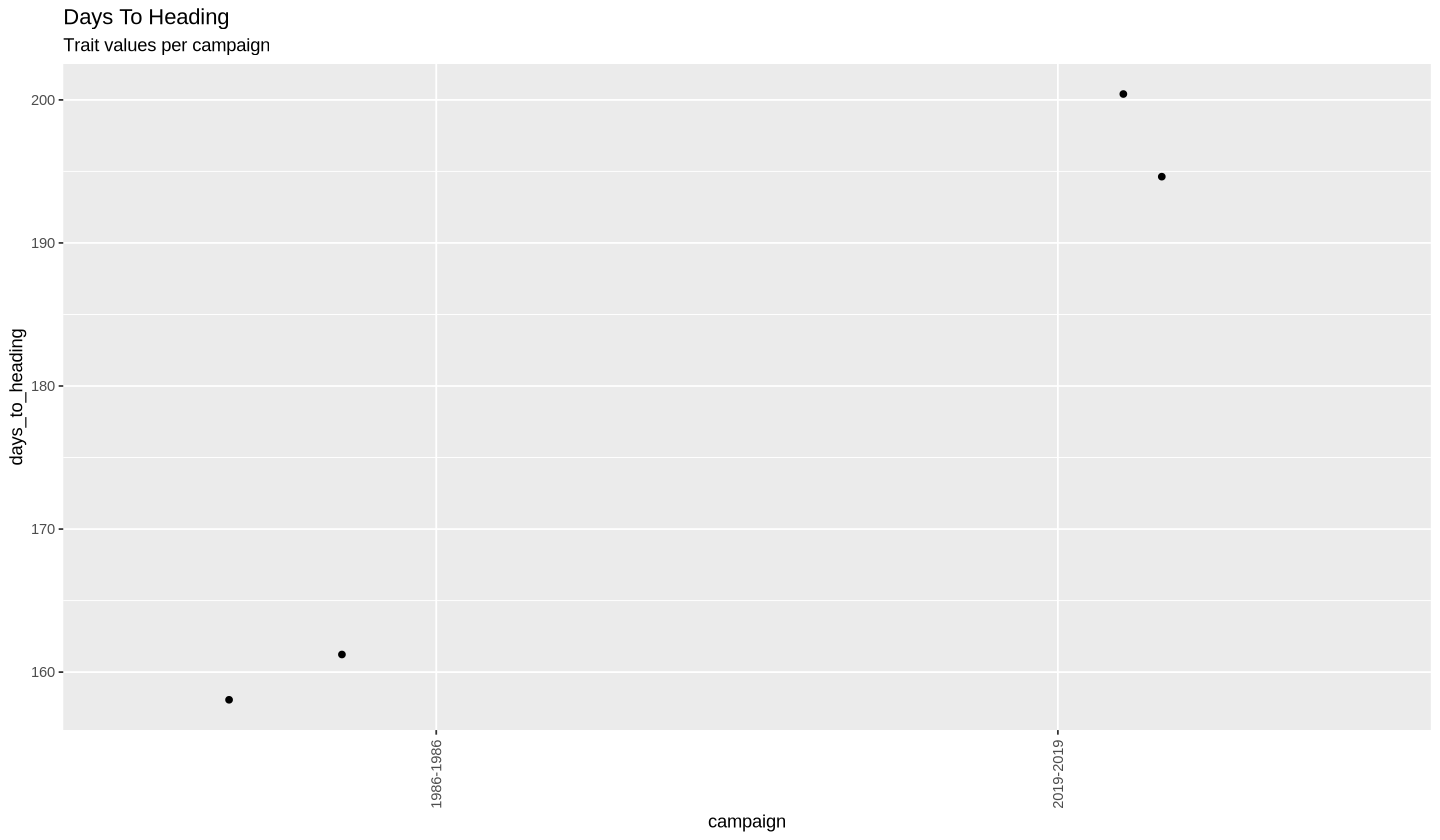

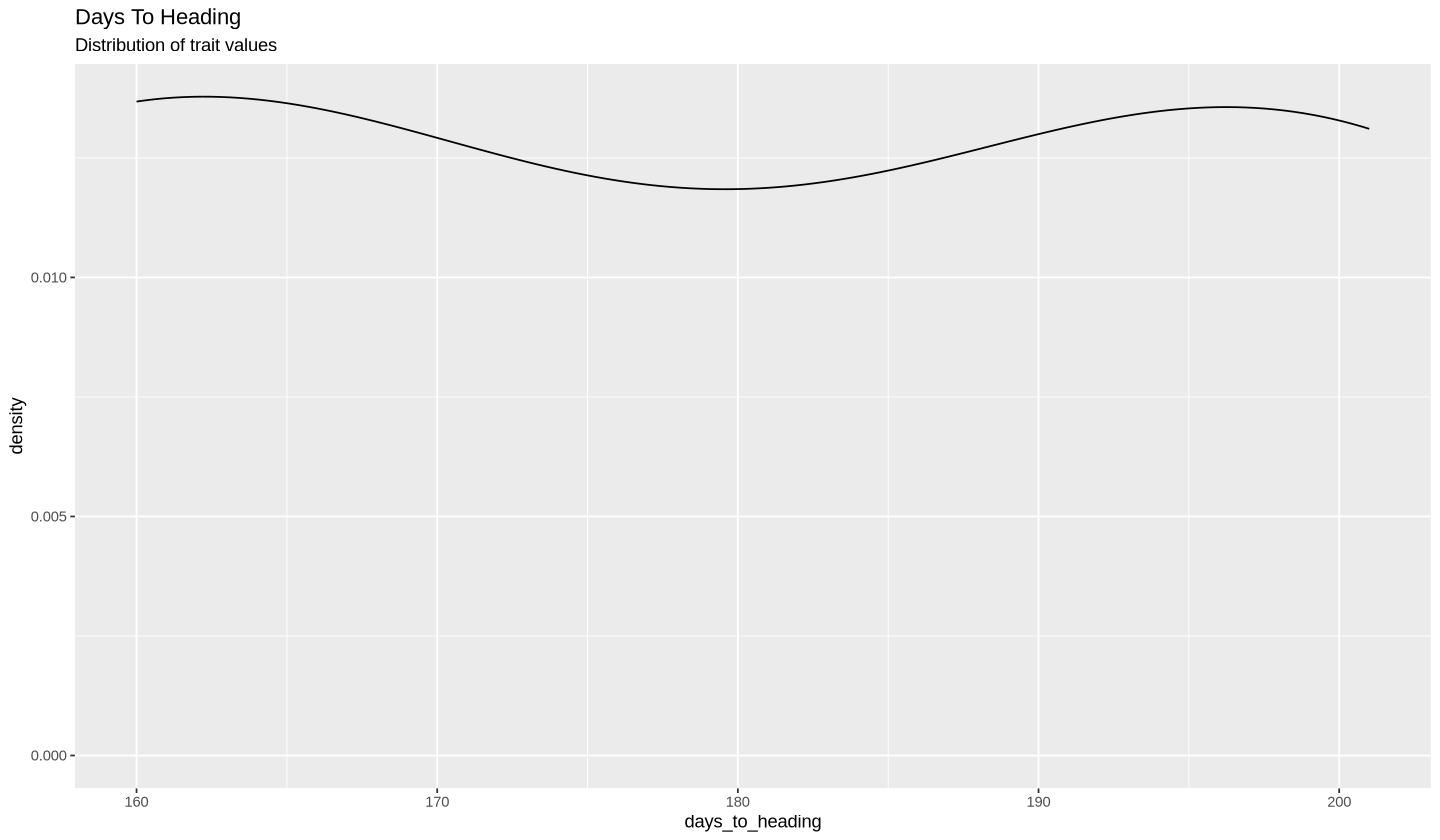

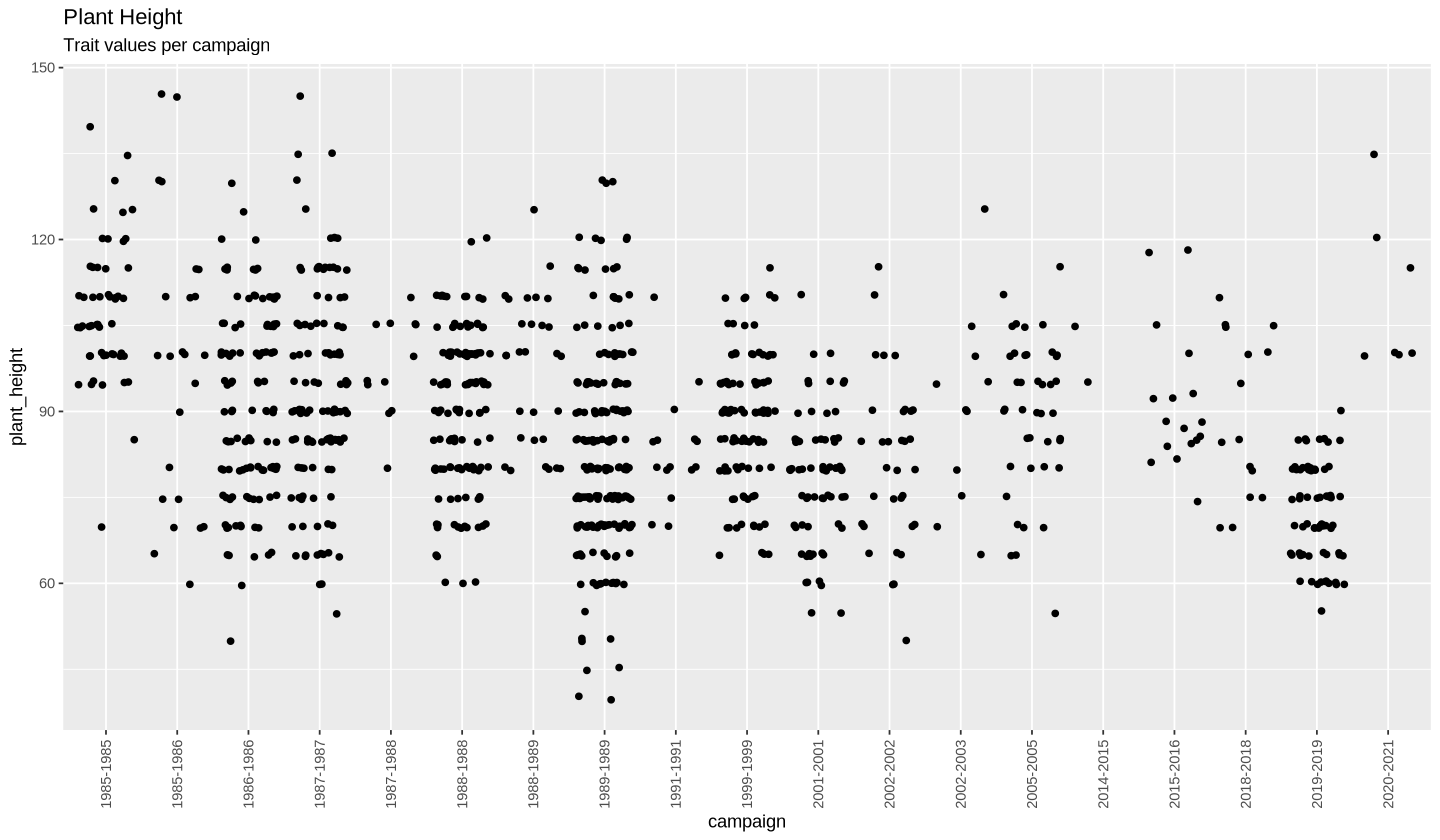

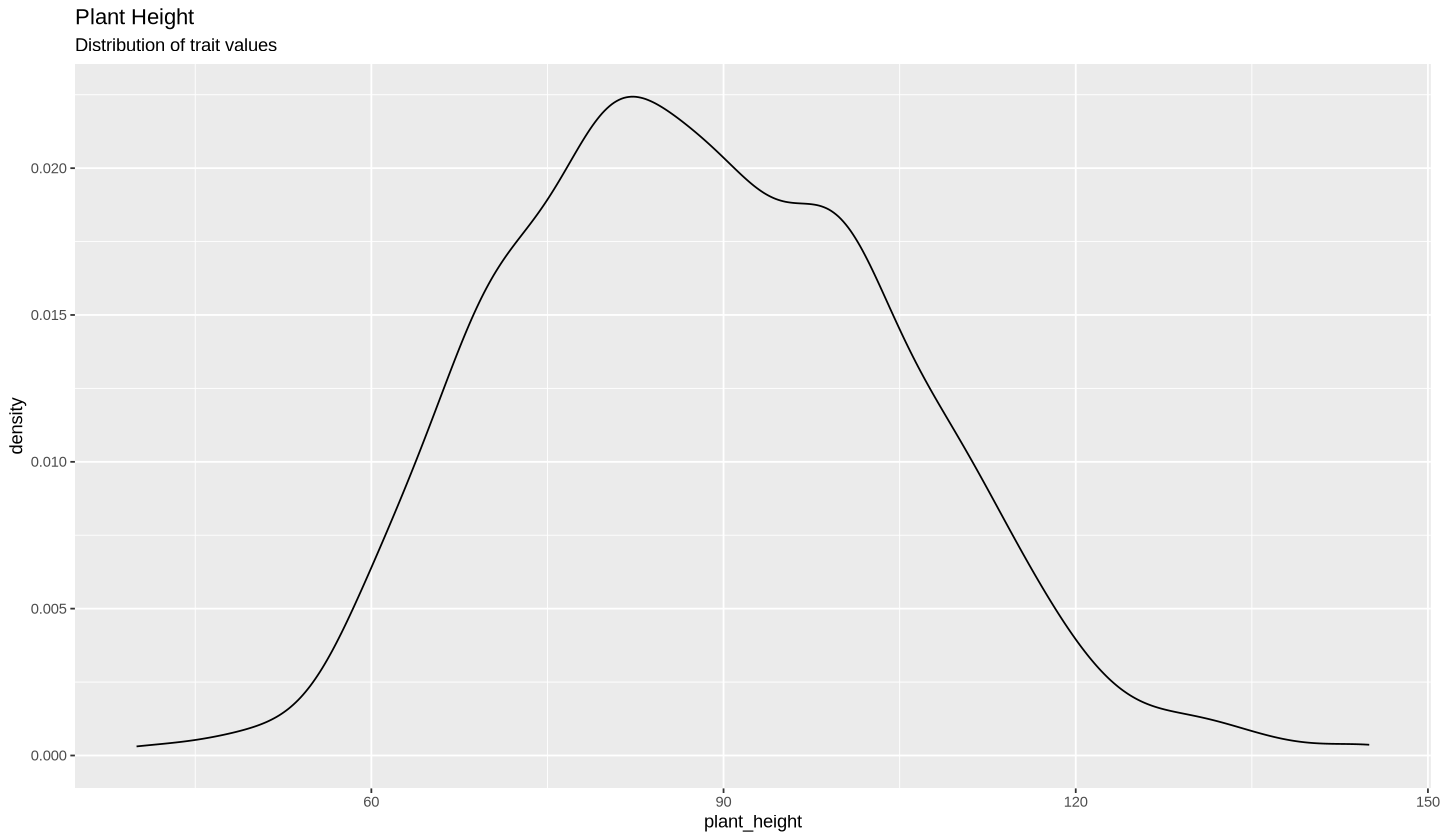

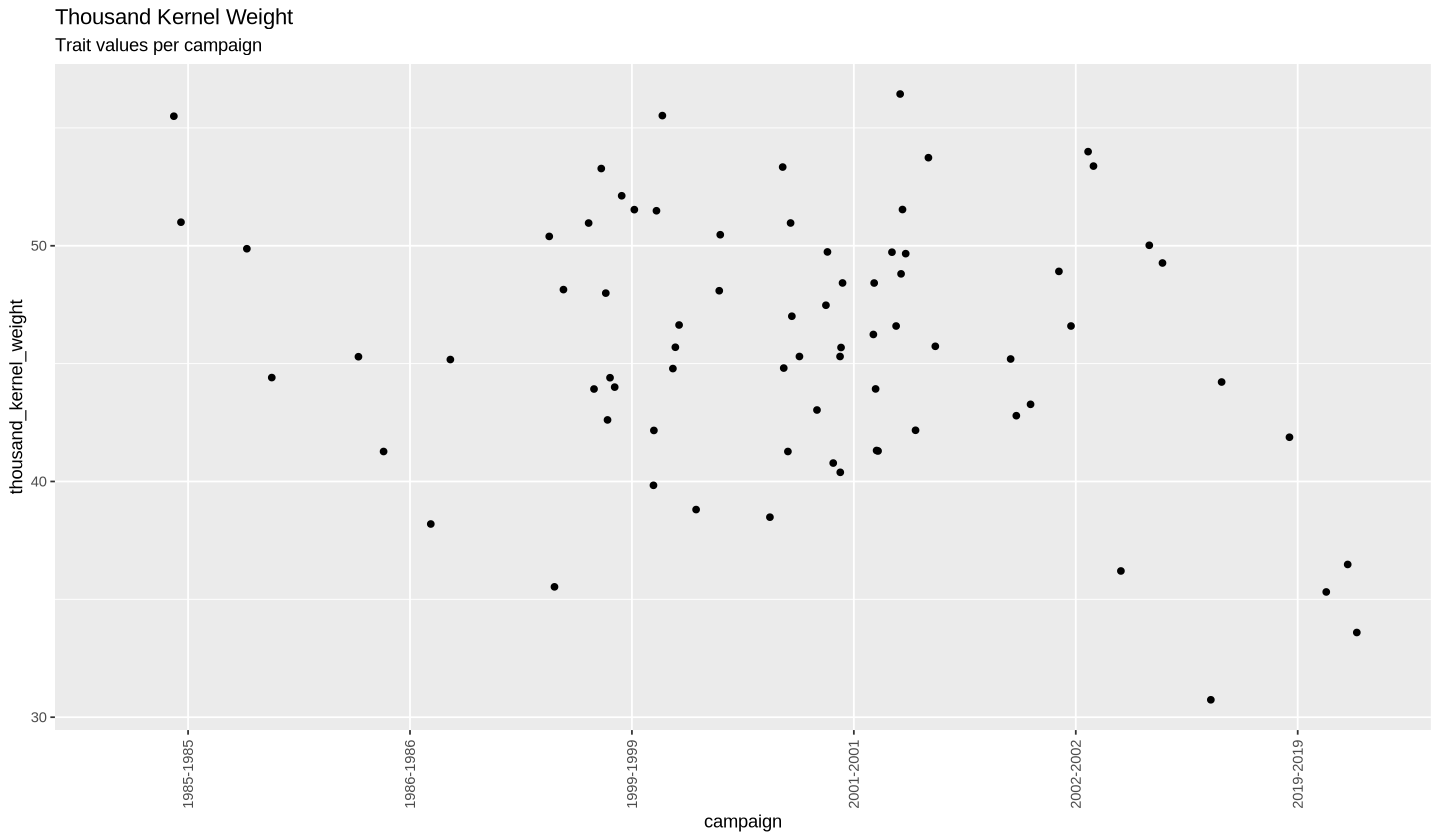

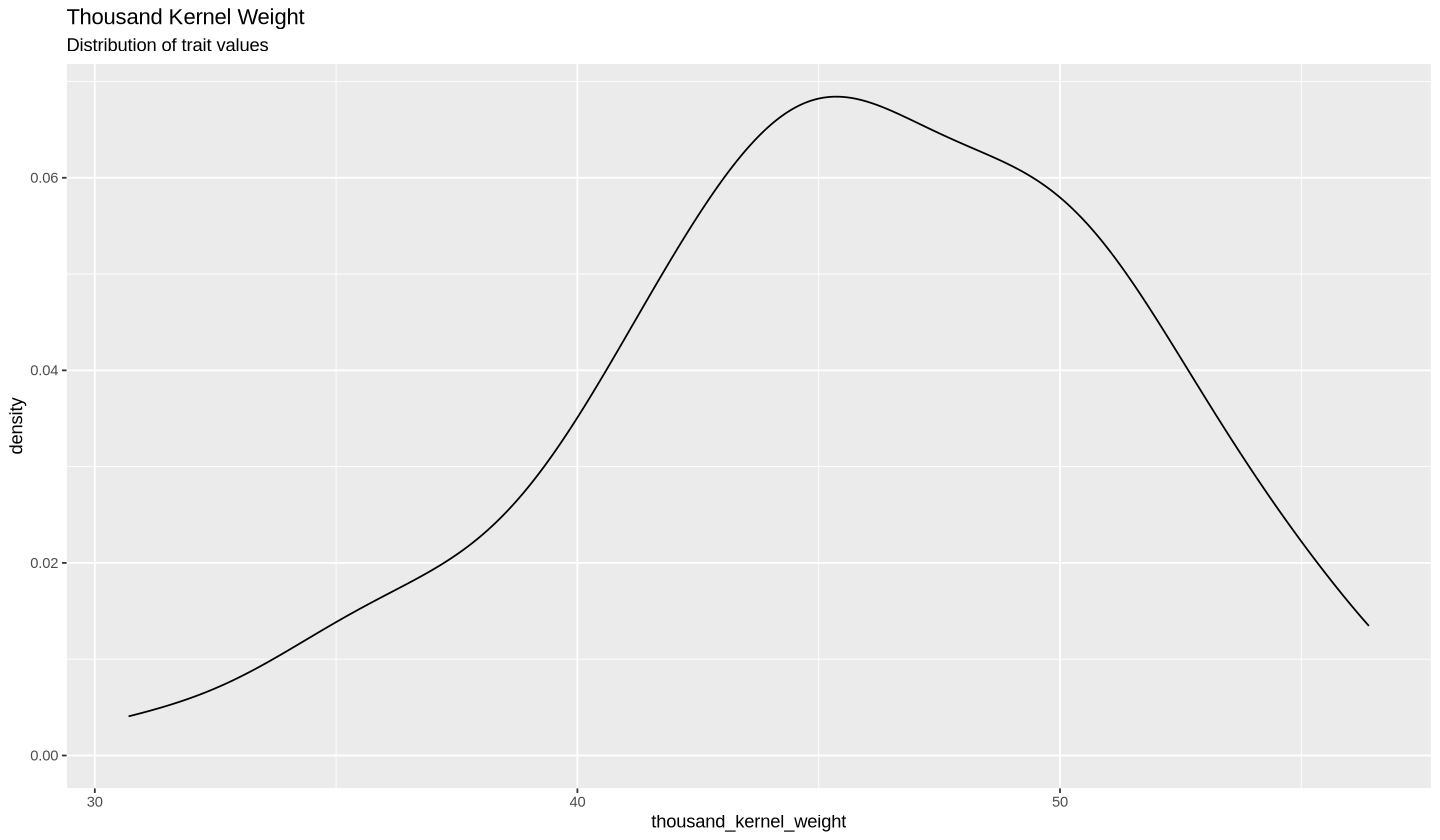

In [4]:
options(repr.plot.width=12, repr.plot.height=7)
data_sub_HT |> visualise_trait(geom_density())
data_sub_PH |> visualise_trait(geom_density())
data_sub_TKW |> visualise_trait(geom_density())

We can see that there are not enough data points for a statistical analysis of the HT and TKW traits 

## Extract and format the campaign effects

In [5]:
asreml_campaign_PH <- asreml(fixed = plant_height ~campaign, random = ~accenumb,
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                             data = data_sub_PH)

In [6]:
campaign_effect_PH <- get_campaign_effect(asreml_campaign_PH)

## Extract heterogeneous error variances

In [7]:
error_var_PH <- get_error_var(asreml_campaign_PH)

## Calculate and standardize the coefficient of variation (CV)

In [8]:
CV_df_PH <- make_CV_df(campaign_effect_PH, error_var_PH)

## Remove outlier campaigns

In [9]:
data_corrected_PH_I <- data_sub_PH |> correct_I(CV_df_PH)

0 outlier campaign(s) detected for trait plant_height


## Residuals

In [10]:
asreml_res_PH <- asreml(fixed = plant_height ~ accenumb, random = ~ campaign, 
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_PH_I)

22 outlier value(s) detected for trait Plant Height 


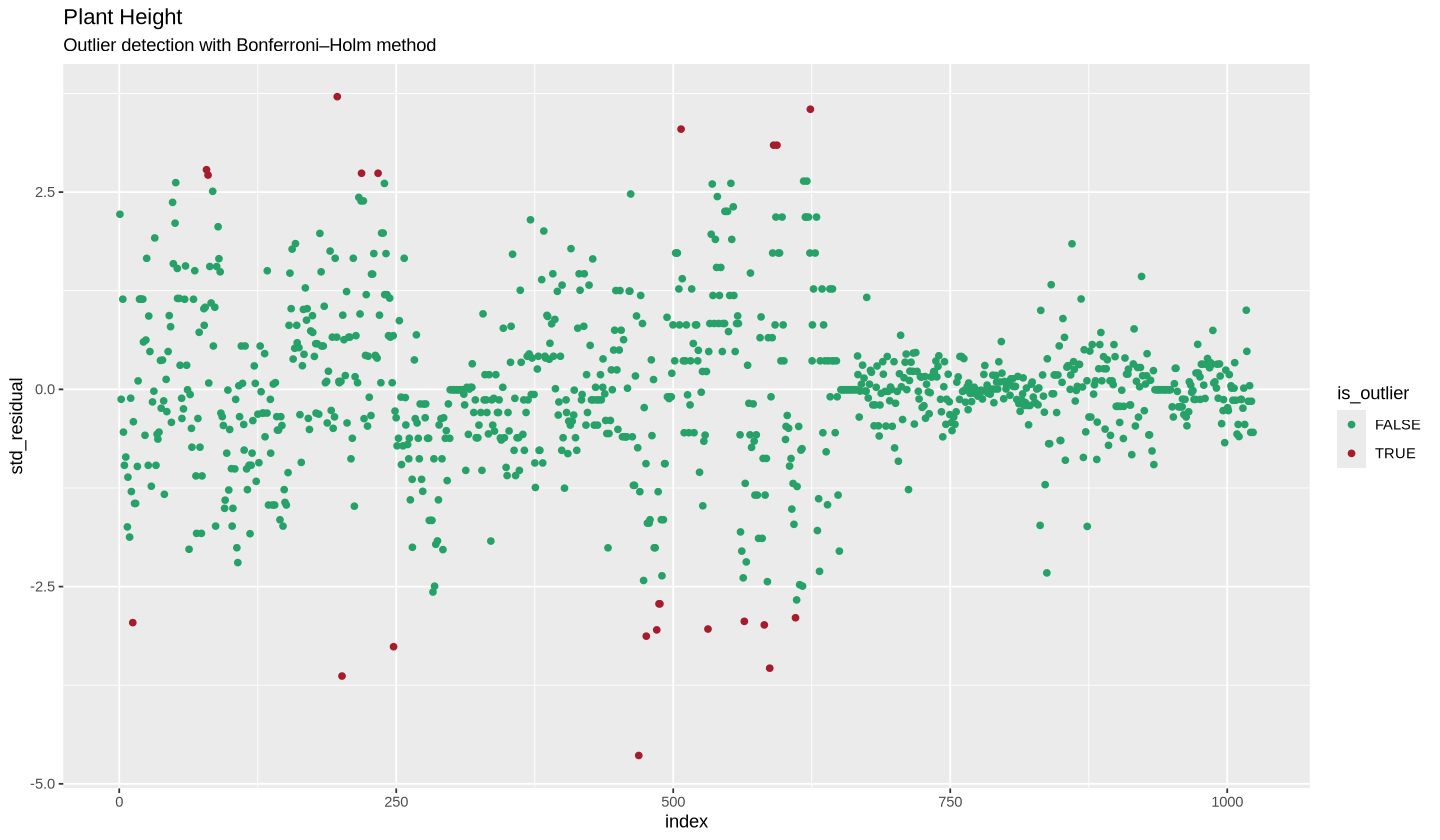

In [11]:
result_BH_PH <- make_BH_multtest(asreml_res_PH)

In [12]:
data_corrected_PH_II <- data_corrected_PH_I |> correct_II(result_BH_PH)
write_csv(data_corrected_PH_II,"data_corrected_PH_II.csv")

## Calculate heritability

In [13]:
asreml_res_h_PH <- asreml(plant_height ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_PH_II)

Warning message in asreml(plant_height ~ 1, random = ~accenumb + campaign, na.action = na.method(x = "omit", :
“Some components changed by more than 1% on the last iteration”


In [14]:
quality_PH <- get_quality(data_sub_PH, asreml_res_h_PH)
quality_all <- quality_PH |> mutate(across(-1, \(x) round(x, 3)))
write_csv(quality_all,"WUR_barley_data_quality.csv")

plant_height heritability: 80.6 %


## Run linear mixed model with outlier corrected data

In [15]:
asreml_data_PH <- asreml(plant_height ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_PH_II)

## Extract BLUEs and create output file

In [16]:
BLUEs_PH <- get_BLUEs(asreml_data_PH)

BLUE_all <- genotypes |> left_join(BLUEs_PH, by="genotype") |> 
            arrange(genotype) |> mutate(across(-1, \(x) round(x, 2)))

write_csv(BLUE_all,"WUR_barley_BLUE_values.csv")
summary(BLUE_all)

   genotype         plant_height_BLUE
 Length:2047        Min.   : 49.63   
 Class :character   1st Qu.: 78.80   
 Mode  :character   Median : 88.25   
                    Mean   : 88.42   
                    3rd Qu.: 97.84   
                    Max.   :138.10   
                    NA's   :1595     

In [17]:
library(rmarkdown)
convert_ipynb("WUR_historic_barley_data_analysis.ipynb")

In [18]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Fedora Linux 40.20240905.0 (Silverblue)

Matrix products: default
BLAS/LAPACK: /var/home/erwan/.conda/envs/R/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Europe/Paris
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] rmarkdown_2.28      asreml_4.2.0.267    Matrix_1.6-5       
 [4] multtest_2.58.0     Biobase_2.62.0      BiocGenerics_0.48.1
 [7] lubridate_1.9.3     forcats_1.0.0       stringr_1.5.1      
[10] dplyr_1.1.4         purrr_1.0.2         readr_2.1.5        
[13] tid